In [1]:
import h5py as h5
import arepo
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic, binned_statistic_2d
from numba import njit
from astropy.io import fits

basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/'

import sys
sys.path.append(basepath+'note/')
import galaxy

import agama
agama.setUnits(mass=1E10, length=1, velocity=1)

In [2]:
GFM_SOLAR_ABUNDANCE_HYDROGEN = 0.7388

GFM_SOLAR_ABUNDANCE_MAGNESIUM = 0.0007
GFM_SOLAR_ABUNDANCE_IRON   =   0.0013

In [3]:
sim0 = ('142', '116', '04')
sim1 = ('129', '116', '04')

In [4]:
def load_galaxy(sim, idx=320):
    if sim=='iso':
        return galaxy.Galaxy(basepath + 'runs/MW7iso/lvl4-Ngb64/output', idx, orient=True)
    else:
        Rs, Vv, ecc = sim
        key = 'lvl4-Rs'+Rs+'-Vv'+Vv+'-e'+ecc
        return galaxy.Galaxy(basepath + 'runs/MW7_GSE4-eRVgrid-lvl4/' + key + '/output',
                                              idx, orient=True)

In [5]:
gal0 = load_galaxy(sim0)
gal1 = load_galaxy(sim1)
gali = load_galaxy('iso')

In [40]:
def get_pot(gal):
    pos_bar = []
    mass_bar = []
    for i in [0, 4]:
        if gal.sn.NumPart_Total[i] > 0:
            part = getattr(gal.sn, 'part'+str(i))
            pos_bar.append(part.rotpos)
            mass_bar.append(part.mass)
    pos_bar = np.concatenate(pos_bar)
    mass_bar = np.concatenate(mass_bar)
    
    pos_halo = gal.sn.part1.rotpos
    mass_halo = np.full(gal.sn.NumPart_Total[1], gal.sn.MassTable[1])
    
    pot_halo = agama.Potential(type="Multipole", particles=(pos_halo, mass_halo),
                           symmetry='a', gridsizeR=20, lmax=2)

    pot_bar  = agama.Potential(type="CylSpline", particles=(pos_bar, mass_bar), 
                          symmetry='a', gridsizer=20, gridsizez=20,
                          mmax=0, Rmin=0.2, Rmax=50, Zmin=0.02, Zmax=10)

    pot_tot = agama.Potential(pot_halo, pot_bar)

    return pot_tot
    
pot0 = get_pot(gal0)
pot1 = get_pot(gal1)
poti = get_pot(gali)

In [41]:
af0 = agama.ActionFinder(pot0)
af1 = agama.ActionFinder(pot1)
afi = agama.ActionFinder(poti)

pts0 = np.hstack([gal0.sn.part4.rotpos, gal0.sn.part4.rotvel])
act0 = af0(pts0)

pts1 = np.hstack([gal1.sn.part4.rotpos, gal1.sn.part4.rotvel])
act1 = af1(pts1)

ptsi = np.hstack([gali.sn.part4.rotpos, gali.sn.part4.rotvel])
acti = afi(ptsi)

In [47]:
def extract_sim_data(gal):
    sn = gal.sn
    
    ### get logFeH and logMgFe ###
    FeH = sn.part4.GFM_Metals[:,8] / GFM_SOLAR_ABUNDANCE_IRON
    MgH = sn.part4.GFM_Metals[:,6] / GFM_SOLAR_ABUNDANCE_MAGNESIUM
    
    logFeH = np.log10(FeH)
    logMgH = np.log10(MgH)
    logMgFe = logMgH - logFeH

    ### get in_SN ###
    Lzsun = 8 * 220 * 0.2
    zmax = 3
    dLz = 0.3
    
    Lz = np.cross(sn.part4.rotpos, sn.part4.rotvel)[:,2]
    in_SN = np.logical_and(np.abs((Lz/Lzsun)-1) < dLz, np.abs(sn.part4.rotpos[:,2]) < zmax)
    
    ### get tform ###
    tform = sn.part4.GFM_StellarFormationTime
    keybool = np.logical_and(in_SN, tform > 0)
    
    ### get pos and vel in cylindrical coordinates ###
    pos, vel = sn.part4.rotpos, sn.part4.rotvel
    rhat = np.copy(pos)
    rhat[:,2] = 0
    rhat /= np.linalg.norm(rhat, axis=1)[:,np.newaxis]
    zhat = np.full_like(pos, np.array([0., 0., 1.]))
    phihat = np.cross(zhat, rhat)
    
    R = np.sum(pos*rhat, axis=1)
    phi = np.arctan2(pos[:,1], pos[:,0])
    z = pos[:,2]
    cylpos = np.transpose([R, phi, z])
    
    velR   = np.sum(vel*rhat, axis=1)
    velphi = np.sum(vel*phihat, axis=1)
    velz   = np.sum(vel*zhat, axis=1)
    cylvel = np.transpose([velR, velphi, velz])
    
    out = {}
    out['logFeH'] = logFeH[in_SN]
    out['logMgFe'] = logMgFe[in_SN]
    out['tform'] = tform[in_SN]
    
    out['cylpos'] = cylpos[in_SN]
    out['cylvel'] = cylvel[in_SN]
    
    out['in_SN'] = in_SN
    
    return out

simdata0 = extract_sim_data(gal0)
simdata1 = extract_sim_data(gal1)
simdatai = extract_sim_data(gali)

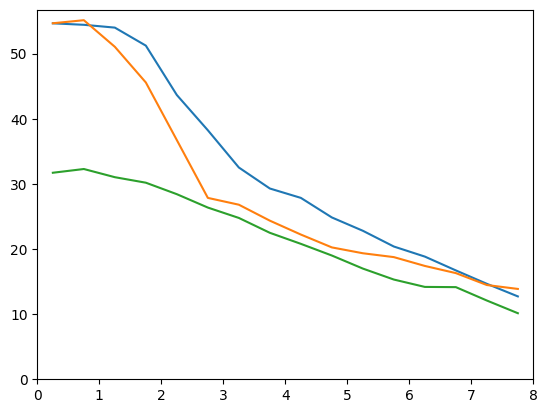

In [43]:
tbins = np.arange(0, 8+0.5, 0.5)

for dat in [simdata0, simdata1, simdatai]:

    vz = dat['cylvel'][:,2]
    tform = dat['tform']

    std_vz, tedges, _ = binned_statistic(tform, vz, statistic='std', bins=tbins)
    tcenter = 0.5 * (tedges[:-1] + tedges[1:])

    plt.plot(tcenter, std_vz)
    
    plt.xlim(0, 8)
    plt.ylim(0, None)

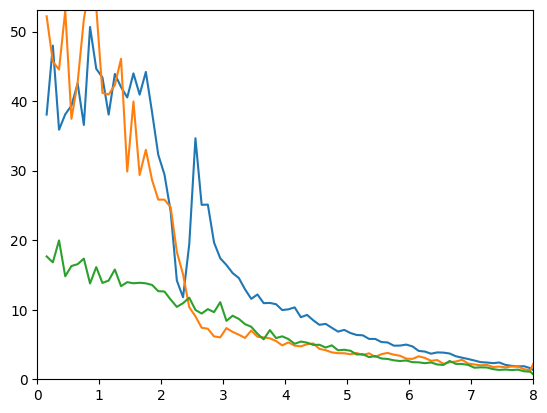

In [44]:
tbins = np.arange(0, 8+0.5, 0.1)

for i,(dat,act) in enumerate(zip([simdata0, simdata1, simdatai], [act0, act1, acti])):

    tform = dat['tform']
    in_SN = dat['in_SN']
    Jz = act[in_SN,1]

    std_vz, tedges, _ = binned_statistic(tform, Jz, statistic='median', bins=tbins)
    tcenter = 0.5 * (tedges[:-1] + tedges[1:])

    plt.plot(tcenter, std_vz)
    
    plt.xlim(0, 8)
    plt.ylim(0, None)

(1.0, 50.0)


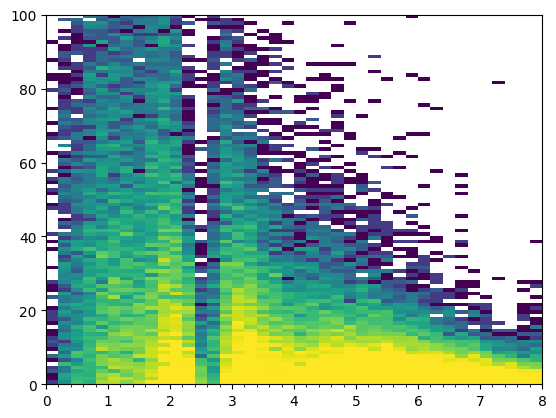

In [53]:
dat = simdata0
act = act0

tform = dat['tform']
in_SN = dat['in_SN']
Jz = act[in_SN,1]

tbins = np.arange(0, 8+0.1, 0.2)
Jzbins = np.arange(0, 100+1, 1)

mbin, tedges, _, _ = binned_statistic_2d(tform, Jz, np.ones_like(tform), 
                                    statistic='sum', bins=[tbins,Jzbins])

fig, ax = plt.subplots(1, 1)
im = ax.imshow(mbin.T, origin='lower', 
               extent=[tbins[0], tbins[-1], Jzbins[0], Jzbins[-1]],
               norm=mpl.colors.LogNorm(1, 50))

print(im.get_clim())

ax.set_aspect('auto')
ax.set_xlim(tbins[0], tbins[-1])
ax.set_xticks(tedges, minor=True);

In [50]:
tedges

array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4,
       2.6, 2.8, 3. , 3.2, 3.4, 3.6, 3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5. ,
       5.2, 5.4, 5.6, 5.8, 6. , 6.2, 6.4, 6.6, 6.8, 7. , 7.2, 7.4, 7.6,
       7.8, 8. ])

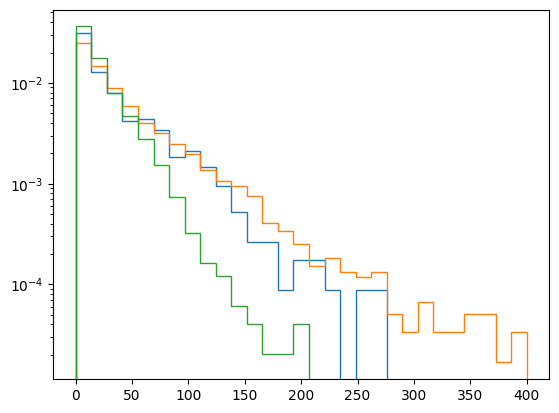

In [58]:
dat = simdata0
act = act0

tform = dat['tform']
in_SN = dat['in_SN']
Jz = act[in_SN,1]

in_merge = np.logical_and(tform > 2.4, tform < 2.8)
bf_merge = np.logical_and(tform > 1.8, tform < 2.2)
af_merge = np.logical_and(tform > 3, tform < 3.4)

plt.hist(Jz[in_merge], histtype='step', density=True, bins=np.linspace(0, 400, 30))
plt.hist(Jz[bf_merge], histtype='step', density=True, bins=np.linspace(0, 400, 30))
plt.hist(Jz[af_merge], histtype='step', density=True, bins=np.linspace(0, 400, 30))

plt.yscale('log')